In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay, f1_score
import time

In [26]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import datasets

In [27]:
train = pd.read_csv('/content/drive/MyDrive/ml lab endsemm/MNIST_train.csv')
val = pd.read_csv('/content/drive/MyDrive/ml lab endsemm/MNIST_validation.csv')
train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,even
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Separate target col and standardise

In [28]:
train_x = train.drop(columns=['label','even'])
train_y = train['label']
val_x = val.drop(columns=['label','even'])
val_y = val['label']

In [29]:
train_x = train_x.to_numpy().astype(np.float64)/255.0
train_y = train_y.to_numpy()
val_x = val_x.to_numpy().astype(np.float64)/255.0
val_y= val_y.to_numpy()

# PCA implementation

In [30]:
class PCAModel:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.explained_variance = None

    def fit(self, X):
        X = np.array(X, dtype=float)
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov_matrix = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        sorted_idx = np.argsort(eigenvalues)[::-1]
        self.explained_variance = eigenvalues[sorted_idx][:self.n_components]
        self.components = eigenvectors[:, sorted_idx][:, :self.n_components]

    def predict(self, X):
        if self.mean is None or self.components is None:
            raise ValueError("The PCA model has not been fitted yet.")
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

    def reconstruct(self, X):
        Z = self.predict(X)

        return np.dot(Z, self.components.T) + self.mean

    def detect_anomalies(self, X, threshold=None, return_errors=False):
        X_reconstructed = self.reconstruct(X)

        errors = np.mean((X - X_reconstructed) ** 2, axis=1)

        if threshold is None:
            threshold = np.percentile(errors, 95)

        flag = errors > threshold

        is_anomaly = flag * 1

        return is_anomaly, errors

# Tuning of no.of components

In [31]:
components_list = [1, 2, 5, 10, 20, 50, 100, 200, 300, 400, 450, 500, 550, 600]
errors_dict = {}
for n in components_list:
    model_pca = PCAModel(n_components=n)
    model_pca.fit(train_x)
    X_reconstructed = model_pca.reconstruct(train_x)
    errors = np.mean((train_x - X_reconstructed) ** 2, axis=1)
    avg_error = np.mean(errors)
    errors_dict[n] = avg_error
for k, err in errors_dict.items():
    print(f"{k} components -> {err:.6f}")

1 components -> 0.060655
2 components -> 0.055934
5 components -> 0.044821
10 components -> 0.034459
20 components -> 0.023952
50 components -> 0.011727
100 components -> 0.005667
200 components -> 0.002202
300 components -> 0.000890
400 components -> 0.000265
450 components -> 0.000119
500 components -> 0.000044
550 components -> 0.000013
600 components -> 0.000002


# Consider top 500 components

In [32]:
pca = PCAModel(n_components=500)
pca.fit(train_x)
train_x_pca = pca.predict(train_x)
val_x_pca = pca.predict(val_x)

# 1.SoftMax Classification

In [33]:
class SoftmaxRegression:
    def __init__(self, learning_rate=0.1, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.W = None
        self.b = None
    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _one_hot(self, y, num_classes):
        return np.eye(num_classes)[y]

    def _cross_entropy_loss(self, y_true, y_pred):
        return -np.mean(np.sum(y_true * np.log(y_pred + 1e-15), axis=1))

    def fit(self, X, y):
        num_samples, num_features = X.shape
        num_classes = np.max(y) + 1
        self.W = np.random.randn(num_features, num_classes) * 0.01
        self.b = np.zeros((1, num_classes))
        Y_onehot = self._one_hot(y, num_classes)
        for epoch in range(self.epochs):
            # Forward pass
            logits = np.dot(X, self.W) + self.b
            probs = self._softmax(logits)
            # Loss (for monitoring)
            loss = self._cross_entropy_loss(Y_onehot, probs)
            grad_logits = (1./ num_samples) * (Y_onehot - probs)
            grad_W = -np.dot(X.T, grad_logits)
            grad_b = -np.sum(grad_logits, axis=0, keepdims=True)
            self.W -= self.learning_rate * grad_W
            self.b -= self.learning_rate * grad_b

            if epoch % 100 == 0 or epoch == self.epochs - 1:
                print(f"Epoch {epoch}: Loss = {loss:.4f}")

    def predict_proba(self, X):
        logits = np.dot(X, self.W) + self.b
        return self._softmax(logits)

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)


Epoch 0: Loss = 2.3293
Epoch 100: Loss = 0.6125
Epoch 200: Loss = 0.4920
Epoch 300: Loss = 0.4415
Epoch 400: Loss = 0.4118
Epoch 499: Loss = 0.3917
Validation Accuracy: 0.8883553421368547
Bias: 0.1786138551567873
Variance: 0.06269975948820421


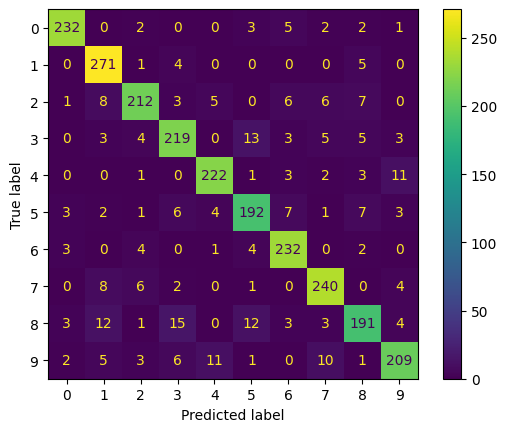

In [34]:
model = SoftmaxRegression(learning_rate=0.1, epochs=500)
model.fit(train_x_pca, train_y)
val_pred = model.predict(val_x_pca)
accuracy = np.mean(val_pred == val_y)
print("Validation Accuracy:", accuracy)
val_proba = model.predict_proba(val_x_pca)
# One-hot true labels
num_classes = np.max(train_y) + 1
val_y_onehot = np.eye(num_classes)[val_y]
bias = np.mean(np.sum((val_proba - val_y_onehot)**2, axis=1))
print("Bias:", bias)
variance = np.mean(np.var(val_proba, axis=1))
print("Variance:", variance)
ConfusionMatrixDisplay(confusion_matrix(val_y, val_pred)).plot()

Epoch 0: Loss = 2.3010
Epoch 100: Loss = 0.6143
Epoch 200: Loss = 0.4923
Epoch 300: Loss = 0.4410
Epoch 400: Loss = 0.4108
Epoch 499: Loss = 0.3903
Validation Accuracy: 0.891156462585034
Bias: 0.17444143278954186
Variance: 0.06229106779833319


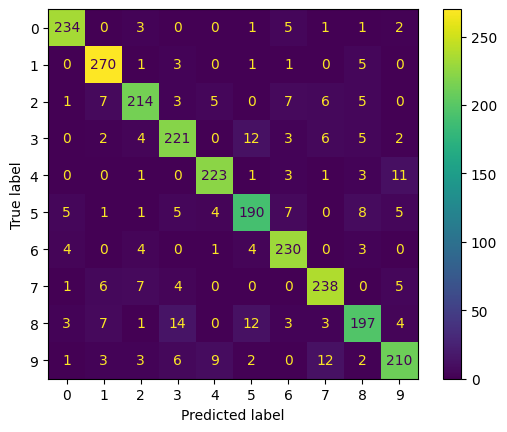

In [ ]:
model = SoftmaxRegression(learning_rate=0.1, epochs=500)
model.fit(train_x, train_y)
val_pred = model.predict(val_x)
accuracy = np.mean(val_pred == val_y)
print("Validation Accuracy:", accuracy)
val_proba = model.predict_proba(val_x)
num_classes = np.max(train_y) + 1
val_y_onehot = np.eye(num_classes)[val_y]

bias = np.mean(np.sum((val_proba - val_y_onehot)**2, axis=1))
print("Bias:", bias)

variance = np.mean(np.var(val_proba, axis=1))
print("Variance:", variance)
ConfusionMatrixDisplay(confusion_matrix(val_y, val_pred)).plot()

In [13]:
for epochs in [200, 400, 500, 700, 900, 1200]:
    model = SoftmaxRegression(learning_rate=0.1, epochs=epochs)
    start_time = time.time()
    model.fit(train_x, train_y)
    val_pred = model.predict(val_x)
    end_time = time.time()
    accuracy = np.mean(val_pred == val_y)

    print("Validation Accuracy:", accuracy)
    print('F1 score:', f1_score(val_y, val_pred, average='macro'))
    print('Time taken(s):', end_time-start_time)
    val_proba = model.predict_proba(val_x)
    num_classes = np.max(train_y) + 1
    val_y_onehot = np.eye(num_classes)[val_y]

    bias = np.mean(np.sum((val_proba - val_y_onehot)**2, axis=1))
    print("Bias:", bias)

    variance = np.mean(np.var(val_proba, axis=1))
    print("Variance:", variance)



Epoch 0: Loss = 2.3073
Epoch 100: Loss = 0.6152
Epoch 199: Loss = 0.4937
Validation Accuracy: 0.8759503801520608
F1 score: 0.8742382232953199
Time taken(s): 12.84092378616333
Bias: 0.21427975571990157
Variance: 0.052748417543892055
Epoch 0: Loss = 2.3118
Epoch 100: Loss = 0.6148
Epoch 200: Loss = 0.4923
Epoch 300: Loss = 0.4409
Epoch 399: Loss = 0.4109
Validation Accuracy: 0.8863545418167267
F1 score: 0.8846680182093273
Time taken(s): 23.41056227684021
Bias: 0.18180233720015057
Variance: 0.060348159379973176
Epoch 0: Loss = 2.3105
Epoch 100: Loss = 0.6145
Epoch 200: Loss = 0.4925
Epoch 300: Loss = 0.4411
Epoch 400: Loss = 0.4109
Epoch 499: Loss = 0.3903
Validation Accuracy: 0.8903561424569828
F1 score: 0.8889014789229117
Time taken(s): 30.75642991065979
Bias: 0.17424312137309086
Variance: 0.06230084711536886
Epoch 0: Loss = 2.2977
Epoch 100: Loss = 0.6148
Epoch 200: Loss = 0.4928
Epoch 300: Loss = 0.4414
Epoch 400: Loss = 0.4111
Epoch 500: Loss = 0.3903
Epoch 600: Loss = 0.3749
Epoch 6

In [16]:
for epochs in [900, 1000, 1500]:
  for l in [0.01, 0.1]:
    model = SoftmaxRegression(learning_rate=l, epochs=epochs)
    start_time = time.time()
    model.fit(train_x_pca, train_y)
    val_pred = model.predict(val_x_pca)
    end_time = time.time()
    print(f'Time(s):',end_time - start_time)
    accuracy = np.mean(val_pred == val_y)
    print("Validation Accuracy:", accuracy)
    print('F1 score:', f1_score(val_y, val_pred, average='macro'))
    val_proba = model.predict_proba(val_x_pca)
    num_classes = np.max(train_y) + 1
    val_y_onehot = np.eye(num_classes)[val_y]
    bias = np.mean(np.sum((val_proba - val_y_onehot)**2, axis=1))
    print("Bias:", bias)
    variance = np.mean(np.var(val_proba, axis=1))
    print("Variance:", variance)

Epoch 0: Loss = 2.3039
Epoch 100: Loss = 1.5316
Epoch 200: Loss = 1.1807
Epoch 300: Loss = 0.9943
Epoch 400: Loss = 0.8791
Epoch 500: Loss = 0.8006
Epoch 600: Loss = 0.7433
Epoch 700: Loss = 0.6996
Epoch 800: Loss = 0.6649
Epoch 899: Loss = 0.6369
Time(s): 36.66659927368164
Validation Accuracy: 0.8475390156062425
F1 score: 0.8455246875234922
Bias: 0.27759984048165126
Variance: 0.04140111465950866
Epoch 0: Loss = 2.2975
Epoch 100: Loss = 0.6114
Epoch 200: Loss = 0.4914
Epoch 300: Loss = 0.4410
Epoch 400: Loss = 0.4114
Epoch 500: Loss = 0.3912
Epoch 600: Loss = 0.3761
Epoch 700: Loss = 0.3641
Epoch 800: Loss = 0.3543
Epoch 899: Loss = 0.3462
Time(s): 34.93760061264038
Validation Accuracy: 0.8951580632252901
F1 score: 0.893823946935975
Bias: 0.16283023299560878
Variance: 0.06670039584104288
Epoch 0: Loss = 2.2960
Epoch 100: Loss = 1.5261
Epoch 200: Loss = 1.1769
Epoch 300: Loss = 0.9919
Epoch 400: Loss = 0.8778
Epoch 500: Loss = 0.7999
Epoch 600: Loss = 0.7431
Epoch 700: Loss = 0.6996
Epo

In [39]:
for epochs in [900, 1000, 1500]:
  for l in [0.01, 0.1]:
    model = SoftmaxRegression(learning_rate=l, epochs=epochs)
    start_time = time.time()
    model.fit(train_x, train_y)
    val_pred = model.predict(val_x)
    end_time = time.time()
    print(f'Time(s):',end_time - start_time)
    accuracy = np.mean(val_pred == val_y)
    print("Validation Accuracy:", accuracy)
    print('F1 score:', f1_score(val_y, val_pred, average='macro'))
    val_proba = model.predict_proba(val_x)
    num_classes = np.max(train_y) + 1
    val_y_onehot = np.eye(num_classes)[val_y]
    bias = np.mean(np.sum((val_proba - val_y_onehot)**2, axis=1))
    print("Bias:", bias)
    variance = np.mean(np.var(val_proba, axis=1))
    print("Variance:", variance)

Epoch 0: Loss = 2.2872
Epoch 100: Loss = 1.5470
Epoch 200: Loss = 1.1915
Epoch 300: Loss = 0.9997
Epoch 400: Loss = 0.8821
Epoch 500: Loss = 0.8026
Epoch 600: Loss = 0.7450
Epoch 700: Loss = 0.7012
Epoch 800: Loss = 0.6664
Epoch 899: Loss = 0.6384
Time(s): 53.54155373573303
Validation Accuracy: 0.858343337334934
F1 score: 0.8556102005509768
Bias: 0.2756322945277797
Variance: 0.04043632676628261
Epoch 0: Loss = 2.3077
Epoch 100: Loss = 0.6139
Epoch 200: Loss = 0.4922
Epoch 300: Loss = 0.4410
Epoch 400: Loss = 0.4108
Epoch 500: Loss = 0.3901
Epoch 600: Loss = 0.3747
Epoch 700: Loss = 0.3625
Epoch 800: Loss = 0.3525
Epoch 899: Loss = 0.3442
Time(s): 54.68641257286072
Validation Accuracy: 0.8999599839935974
F1 score: 0.8986192531768804
Bias: 0.15837870111304808
Variance: 0.06646865624296824
Epoch 0: Loss = 2.3092
Epoch 100: Loss = 1.5608
Epoch 200: Loss = 1.2002
Epoch 300: Loss = 1.0055
Epoch 400: Loss = 0.8862
Epoch 500: Loss = 0.8056
Epoch 600: Loss = 0.7474
Epoch 700: Loss = 0.7030
Epoc

# KNN

In [23]:
class KNNClassifier:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _euclidean_distance(self, a, b):
        return np.sqrt(np.sum((a - b)**2, axis=1))

    def predict_one(self, x):
        distances = self._euclidean_distance(self.X_train, x)
        k_idx = np.argsort(distances)[:self.k]
        k_labels = self.y_train[k_idx]
        return np.bincount(k_labels).argmax()

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])


In [ ]:
k_values = [3,5,7,9,11,15]
for k in k_values:
    knn = KNNClassifier(k=k)
    knn.fit(train_x_pca, train_y)
    # Predict on validation
    start_time = time.time()
    val_pred = knn.predict(val_x_pca)
    end_time = time.time()
    # Accuracy
    accuracy = np.mean(val_pred == val_y)
    print("KNN Validation Accuracy:", accuracy)
    print("f1_score:", f1_score(val_y, val_pred, average='macro'))
    print('Time taken(s):', end_time-start_time)



KNN Validation Accuracy: 0.9507803121248499
f1_score: 0.9502816929976939
Time taken(s): 7.361982822418213
KNN Validation Accuracy: 0.9519807923169268
f1_score: 0.9519020504355534
Time taken(s): 8.210355520248413
KNN Validation Accuracy: 0.9539815926370548
f1_score: 0.9539090968131552
Time taken(s): 7.156310081481934
KNN Validation Accuracy: 0.9495798319327731
f1_score: 0.9492970651721659
Time taken(s): 8.270536184310913
KNN Validation Accuracy: 0.9471788715486195
f1_score: 0.9469156368286014
Time taken(s): 7.3258583545684814
KNN Validation Accuracy: 0.9439775910364145
f1_score: 0.9438056958637377
Time taken(s): 8.15033769607544


In [24]:
k_values = [3,5,7,9,11,15]
for k in k_values:
    knn = KNNClassifier(k=k)
    knn.fit(train_x, train_y)
    # Predict on validation
    start_time = time.time()
    val_pred = knn.predict(val_x)
    end_time = time.time()
    # Accuracy
    accuracy = np.mean(val_pred == val_y)
    print("KNN Validation Accuracy:", accuracy)
    print("f1_score:", f1_score(val_y, val_pred, average='macro'))
    print('Time taken(s):', end_time-start_time)


KNN Validation Accuracy: 0.9455782312925171
f1_score: 0.9450000433961504
Time taken(s): 89.54694199562073
KNN Validation Accuracy: 0.9503801520608244
f1_score: 0.950294538185506
Time taken(s): 88.39099740982056
KNN Validation Accuracy: 0.9447779111644657
f1_score: 0.9447734740639826
Time taken(s): 88.04321670532227
KNN Validation Accuracy: 0.9439775910364145
f1_score: 0.9439622507803482
Time taken(s): 87.93651676177979
KNN Validation Accuracy: 0.9403761504601841
f1_score: 0.9401036702236165
Time taken(s): 87.85509490966797
KNN Validation Accuracy: 0.9339735894357744
f1_score: 0.9338241088643418
Time taken(s): 88.23540830612183


# Boosting

In [18]:
class tree_node:
    def __init__(self, feature_idx=None, threshold=None, left_node=None, right_node=None, leaf_value=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left_node = left_node
        self.right_node = right_node
        self.leaf_value = leaf_value

class XGBoostMultiClass:
    def __init__(self, num_classes, n_estimators=200, learning_rate=0.2, max_depth=5):
        self.K = num_classes
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.init_scores = None

    def softmax(self, logits):
        logits = logits - np.max(logits, axis=1, keepdims=True)
        exp_vals = np.exp(logits)
        return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

    def build(self, X, grad, hess, depth):
        if depth >= self.max_depth or len(X) == 0:
            leaf_value = -np.sum(grad) / (np.sum(hess) + 1e-8)
            return tree_node(leaf_value=leaf_value)

        G_total, H_total = np.sum(grad), np.sum(hess)
        best_gain = -float('inf')
        best_feat = None
        best_thresh = None
        best_left = best_right = None

        feature_count = int(np.sqrt(X.shape[1])) + 1
        feature_indices = np.random.choice(X.shape[1], feature_count, replace=False)

        for j in feature_indices:
            values = np.unique(X[:, j])
            thresholds = np.random.choice(values, min(10, len(values)), replace=False)

            for threshold in thresholds:
                left = X[:, j] <= threshold
                right = ~left

                if not np.any(left) or not np.any(right):
                    continue

                G_l, H_l = np.sum(grad[left]), np.sum(hess[left])
                G_r, H_r = np.sum(grad[right]), np.sum(hess[right])

                gain = 0.5 * (
                    G_l**2 / (H_l + 1e-8) +
                    G_r**2 / (H_r + 1e-8) -
                    G_total**2 / (H_total + 1e-8)
                )

                if gain > best_gain:
                    best_gain = gain
                    best_feat = j
                    best_thresh = threshold
                    best_left = left
                    best_right = right

        if best_gain == -float('inf'):
            leaf_value = -np.sum(grad) / (np.sum(hess) + 1e-8)
            return tree_node(leaf_value=leaf_value)

        left_node = self.build(X[best_left],  grad[best_left],  hess[best_left],  depth+1)
        right_node = self.build(X[best_right], grad[best_right], hess[best_right], depth+1)

        return tree_node(feature_idx=best_feat, threshold=best_thresh,
                         left_node=left_node, right_node=right_node)

    def pred_one(self, x, node):
        while node.leaf_value is None:
            if x[node.feature_idx] <= node.threshold:
                node = node.left_node
            else:
                node = node.right_node
        return node.leaf_value
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        N = len(y)

        Y = np.eye(self.K)[y]

        scores = np.zeros((N, self.K))
        self.init_scores = np.zeros(self.K)

        self.trees = []

        for m in range(self.n_estimators):
            probs = self.softmax(scores)
            grad = probs - Y
            hess = probs * (1 - probs)

            round_trees = []
            for k in range(self.K):
                tree = self.build(X, grad[:, k], hess[:, k], depth=0)
                update = np.array([self.pred_one(row, tree) for row in X])
                scores[:, k] += self.learning_rate * update

                round_trees.append(tree)

            self.trees.append(round_trees)
    def predict(self, X):
        X = np.asarray(X)
        N = X.shape[0]

        scores = np.zeros((N, self.K))

        for round_trees in self.trees:
            for k in range(self.K):
                update = np.array([self.pred_one(row, round_trees[k]) for row in X])
                scores[:, k] += self.learning_rate * update

        probs = self.softmax(scores)
        return np.argmax(probs, axis=1)

    def predict_proba(self, X):
        X = np.asarray(X)
        N = X.shape[0]

        scores = np.zeros((N, self.K))

        for round_trees in self.trees:
            for k in range(self.K):
                update = np.array([self.pred_one(row, round_trees[k]) for row in X])
                scores[:, k] += self.learning_rate * update

        return self.softmax(scores)


In [19]:
model = XGBoostMultiClass(num_classes=10, n_estimators=50, learning_rate=0.2, max_depth=5)
starttime = time.time()
model.fit(train_x, train_y)
ypred = model.predict(val_x)
print("Time taken:", time.time() - starttime)
print("Accuracy:", accuracy_score(val_y, ypred))
print("F1 Score:", f1_score(val_y, ypred, average='macro'))

Time taken: 322.7749185562134
Accuracy: 0.9443777511004402
F1 Score: 0.9440543945804677


In [21]:
for n in [50, 100]:
  for d in [3, 5]:
    model = XGBoostMultiClass(num_classes=10, n_estimators=n, learning_rate=0.2, max_depth=d)
    starttime = time.time()
    model.fit(train_x, train_y)
    ypred = model.predict(val_x)
    print("Time taken:", time.time() - starttime)
    print("Accuracy:", accuracy_score(val_y, ypred))
    print("F1 Score:", f1_score(val_y, ypred, average='macro'))

Time taken: 161.45142674446106
Accuracy: 0.9287715086034414
F1 Score: 0.9281360823512805
Time taken: 324.7146408557892
Accuracy: 0.9531812725090036
F1 Score: 0.9529093495229736
Time taken: 323.59684348106384
Accuracy: 0.9367747098839536
F1 Score: 0.9362472392137653
Time taken: 646.3272078037262
Accuracy: 0.9571828731492596
F1 Score: 0.9569910842936279


# Bagging

In [36]:
from collections import Counter

class DecisionTree:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def gini(self, y):
        m = len(y)
        if m == 0:
            return 0
        counts = np.bincount(y)
        probs = counts / m
        return 1 - np.sum(probs ** 2)

    def best_split(self, X, y):
        m, n = X.shape
        best_feature, best_thresh = None, None
        best_gini = float('inf')

        for feature in range(n):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left = X[:, feature] <= t
                right = ~left

                if left.sum() == 0 or right.sum() == 0:
                    continue

                g_left = self.gini(y[left])
                g_right = self.gini(y[right])

                weighted = (left.sum()*g_left + right.sum()*g_right) / m

                if weighted < best_gini:
                    best_gini = weighted
                    best_feature = feature
                    best_thresh = t

        return best_feature, best_thresh

    def build_tree(self, X, y, depth=0):
        m, n = X.shape
        num_classes = len(np.unique(y))

        if depth >= self.max_depth or num_classes == 1 or m < self.min_samples_split:
            return Counter(y).most_common(1)[0][0]

        feature, thresh = self.best_split(X, y)
        if feature is None:
            return Counter(y).most_common(1)[0][0]

        left = X[:, feature] <= thresh
        right = ~left

        left_branch = self.build_tree(X[left], y[left], depth+1)
        right_branch = self.build_tree(X[right], y[right], depth+1)

        return {"feature": feature, "threshold": thresh,
                "left": left_branch, "right": right_branch}

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def predict_one(self, x, node):
        if not isinstance(node, dict):
            return node
        if x[node["feature"]] <= node["threshold"]:
            return self.predict_one(x, node["left"])
        else:
            return self.predict_one(x, node["right"])

    def predict(self, X):
        return np.array([self.predict_one(x, self.tree) for x in X])

In [37]:
class BaggingClassifier:
    def __init__(self, n_estimators=10, max_depth=10):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def bootstrap(self, X, y):
        m = len(X)
        idx = np.random.choice(m, m, replace=True)
        return X[idx], y[idx]

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            X_s, y_s = self.bootstrap(X, y)
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_s, y_s)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # shape = (n_trees, n_samples)

        final_preds = []
        for i in range(tree_preds.shape[1]):
            votes = Counter(tree_preds[:, i])
            final_preds.append(votes.most_common(1)[0][0])

        return np.array(final_preds)


In [ ]:
bag = BaggingClassifier(n_estimators=20, max_depth=12)
bag.fit(train_x, train_y)
pred = bag.predict(val_x)
print("Accuracy:", accuracy_score(val_y, pred))
print("F1 Score:", f1_score(val_y, pred, average='macro'))